In [ ]:
from Meningioma.preprocessing.tools.remove_extra_channels import remove_first_channel
from Meningioma.preprocessing.tools.casting import cast_volume_and_mask
from Meningioma.preprocessing.tools.nrrd_to_nifti import nifti_write_3d
from Meningioma.preprocessing.tools.denoise_susan import denoise_susan
from Meningioma.preprocessing.tools.bias_field_corr_n4 import n4_bias_field_correction, generate_brain_mask_sitk
from Meningioma.preprocessing.tools.skull_stripping.fsl_bet import fsl_bet_brain_extraction


import os

import SimpleITK as sitk

import matplotlib.pyplot as plt

PATH = "/home/mariopasc/Python/Datasets/Meningiomas"
ATLAS = "/home/mariopasc/Python/Datasets/Meningiomas/ATLAS/sri24_spm8/templates/T1_brain.nii"
INPUT_PATH = os.path.join(PATH, "Meningioma_Adquisition")
OUTPUT_PATH = os.path.join(PATH, "output")
if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)
MODALITY = "RM"
PULSES = ["T1", "T2", "SUSC"]
PATIENT = "1"

data = {}
for pulse in PULSES:
    vol_path = os.path.join(INPUT_PATH, MODALITY, pulse, f"P{PATIENT}", f"{pulse}_P{PATIENT}.nrrd")
    seg_path = os.path.join(INPUT_PATH, MODALITY, pulse, f"P{PATIENT}", f"{pulse}_P{PATIENT}_seg.nrrd")
    data[pulse] = {"vol": vol_path, "seg": seg_path}

    print("=====================================")
    print(f"Processing {pulse}")
    print("=====================================")

    # Load and save paths
    vol_path = data[pulse]["vol"]
    seg_path = data[pulse]["seg"]
    
    # Remove first channel
    vol, hdr = remove_first_channel(nrrd_path=vol_path, channel=0, verbose=True)
    seg, hdr_seg = remove_first_channel(nrrd_path=seg_path, channel=0, verbose=True)
    # Cast volume and mask
    vol, seg = cast_volume_and_mask(volume_img=vol, mask_img=seg)

    # n4 bias field correction
    _, mask_brain = generate_brain_mask_sitk(volume_sitk=vol)
    vol = n4_bias_field_correction(volume_sitk=vol, verbose=True)

    # save files
    nifti_write_3d([vol, hdr], os.path.join(OUTPUT_PATH, f"{pulse}_P{PATIENT}"))
    nifti_write_3d([seg, hdr_seg], os.path.join(OUTPUT_PATH, f"{pulse}_P{PATIENT}_seg"))
    # Save
    data[pulse] = {
        "input_paths": {
            "vol": vol_path,
            "seg": seg_path,
        },
        "arrays": {
            "vol": sitk.GetArrayFromImage(vol),
            "seg": sitk.GetArrayFromImage(seg),
        },
        "output_paths": {
            "vol": os.path.join(OUTPUT_PATH, f"{pulse}_P{PATIENT}.nii.gz"),
            "seg": os.path.join(OUTPUT_PATH, f"{pulse}_P{PATIENT}_seg.nii.gz"),
        }
        
    }

Processing T1
Input volume shape: (416, 512, 192)
Input hdr fields:
 - dimensions: 3
 - sizes: [416 512 192]
 - space directions: [[ 0.46754256838748026 -0.01235863904309036  0.03126936658522083]
 [ 0.01877844950535475  0.45759081350102976 -0.09992286892218787]
 [-0.05533471886129857  0.20022161611266281  0.9065039159753452 ]]
 - kinds: ['domain', 'domain', 'domain']
 - space origin: [ -97.39358329164699 -146.91877981590994  -70.622476993478  ]
Input volume shape: (416, 512, 192)
Input hdr fields:
 - dimensions: 3
 - sizes: [416 512 192]
 - space directions: [[ 0.46754256838748026 -0.01235863904309036  0.03126936658522083]
 [ 0.01877844950535475  0.45759081350102976 -0.09992286892218787]
 [-0.05533471886129857  0.20022161611266281  0.9065039159753452 ]]
 - kinds: ['domain', 'domain', 'domain']
 - space origin: [ -97.39358329164699 -146.91877981590994  -70.622476993478  ]
[N4] Starting bias field correction with the following params:
  shrink_factor=4, max_iterations=50, bias_field_fwhm

Processing T1
Input volume shape: (416, 512, 192)
Input hdr fields:
 - dimensions: 3
 - sizes: [416 512 192]
 - space directions: [[ 0.46754257 -0.01235864  0.03126937]
 [ 0.01877845  0.45759081 -0.09992287]
 [-0.05533472  0.20022162  0.90650392]]
 - kinds: ['domain', 'domain', 'domain']
 - space origin: [ -97.39358329 -146.91877982  -70.62247699]
[N4] Starting bias field correction with the following params:
  shrink_factor=4, max_iterations=50, bias_field_fwhm=0.15, control_points=[4, 4, 4]
[N4] Finished correction at level 4, last convergence measurement=0.0013327518245205283
Processing T2
Input volume shape: (320, 320, 21)
Input hdr fields:
 - dimensions: 3
 - sizes: [320 320  21]
 - space directions: [[ 0.6857291  -0.018126    0.04586174]
 [ 0.02754173  0.67113319 -0.14655354]
 [-0.392698    1.42092757  6.43325349]]
 - kinds: ['domain', 'domain', 'domain']
 - space origin: [-111.16775554 -131.91836989  -45.44134392]
[N4] Starting bias field correction with the following params:
  

In [27]:
bet = {}

for pulse in intermediate.keys():
    
    print("=====================================")
    print(f"Processing {pulse}")
    print("=====================================")

    # Load and save paths
    vol = intermediate[pulse]["vol"]
    seg = intermediate[pulse]["seg"]
    denoised = intermediate[pulse]["denoised"]
    mask_brain = intermediate[pulse]["mask_brain"]

    # Skull stripping
    brain_n4, mask_n4 = fsl_bet_brain_extraction(input_image_sitk=vol, robust=True,verbose=True)
    brain_susan, mask_susan = fsl_bet_brain_extraction(input_image_sitk=denoised, robust=True, verbose=True)

    # Save
    bet[pulse] = {
        "brain_n4": brain_n4,
        "brain_susan": brain_susan, 
        "mask_n4": mask_n4,
        "mask_susan": mask_susan
    }

Processing T1
[FSL BET] Running BET with frac=0.5, robust=True, vertical_gradient=0.0, skull=False
[FSL BET] Completed. Outputs:

inskull_mask_file = <undefined>
inskull_mesh_file = <undefined>
mask_file = /tmp/tmpdq7ke87w/bet_out_mask.nii.gz
meshfile = <undefined>
out_file = /tmp/tmpdq7ke87w/bet_out.nii.gz
outline_file = <undefined>
outskin_mask_file = <undefined>
outskin_mesh_file = <undefined>
outskull_mask_file = <undefined>
outskull_mesh_file = <undefined>
skull_file = <undefined>
skull_mask_file = <undefined>

[FSL BET] Running BET with frac=0.5, robust=True, vertical_gradient=0.0, skull=False
[FSL BET] Completed. Outputs:

inskull_mask_file = <undefined>
inskull_mesh_file = <undefined>
mask_file = /tmp/tmpxceriqt6/bet_out_mask.nii.gz
meshfile = <undefined>
out_file = /tmp/tmpxceriqt6/bet_out.nii.gz
outline_file = <undefined>
outskin_mask_file = <undefined>
outskin_mesh_file = <undefined>
outskull_mask_file = <undefined>
outskull_mesh_file = <undefined>
skull_file = <undefined>
s

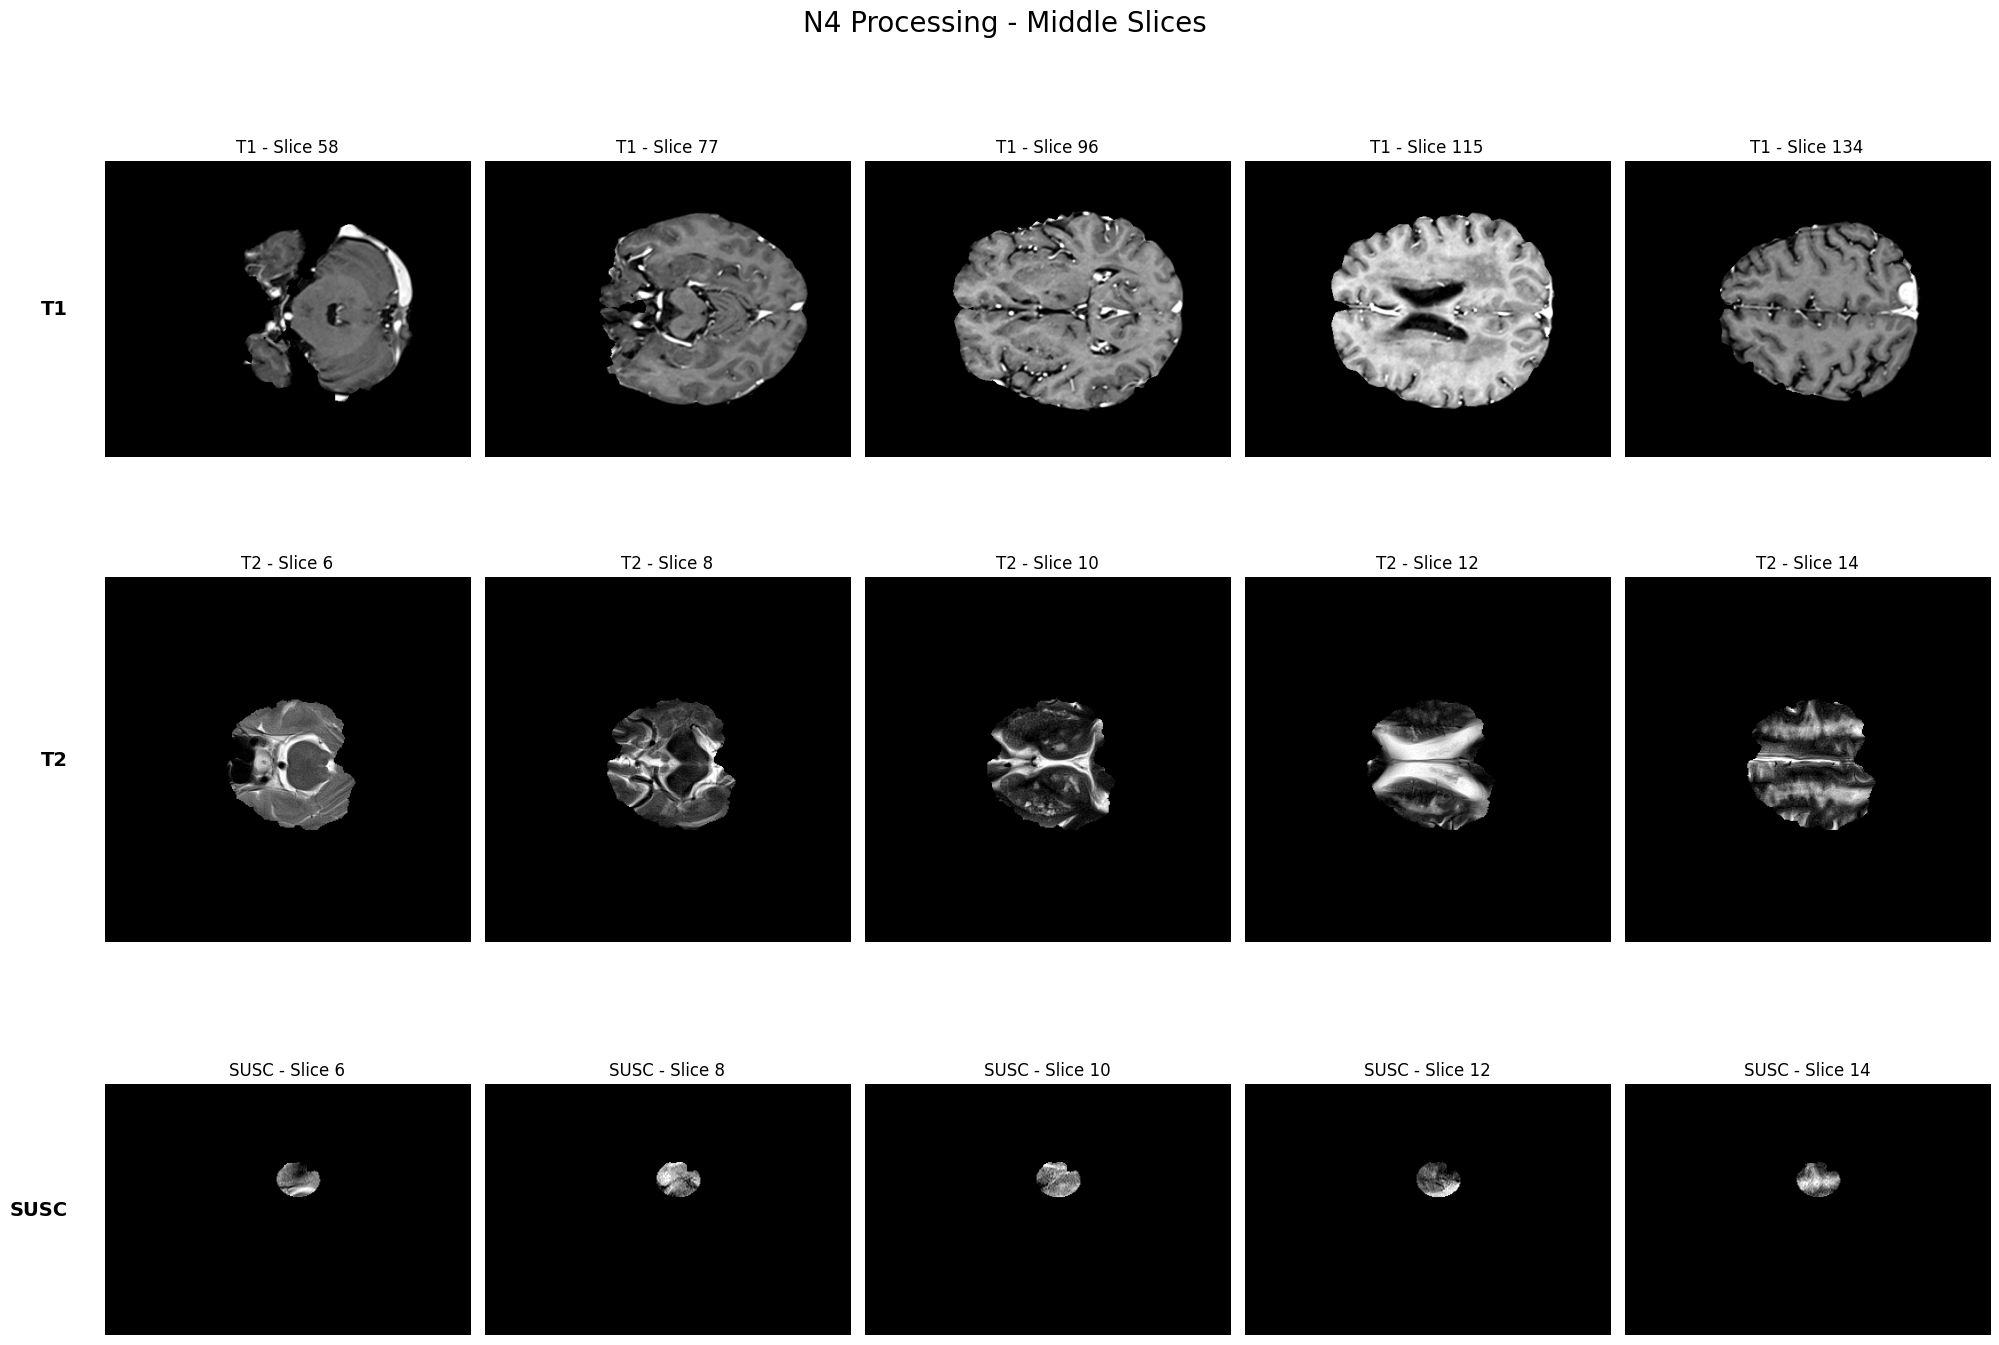

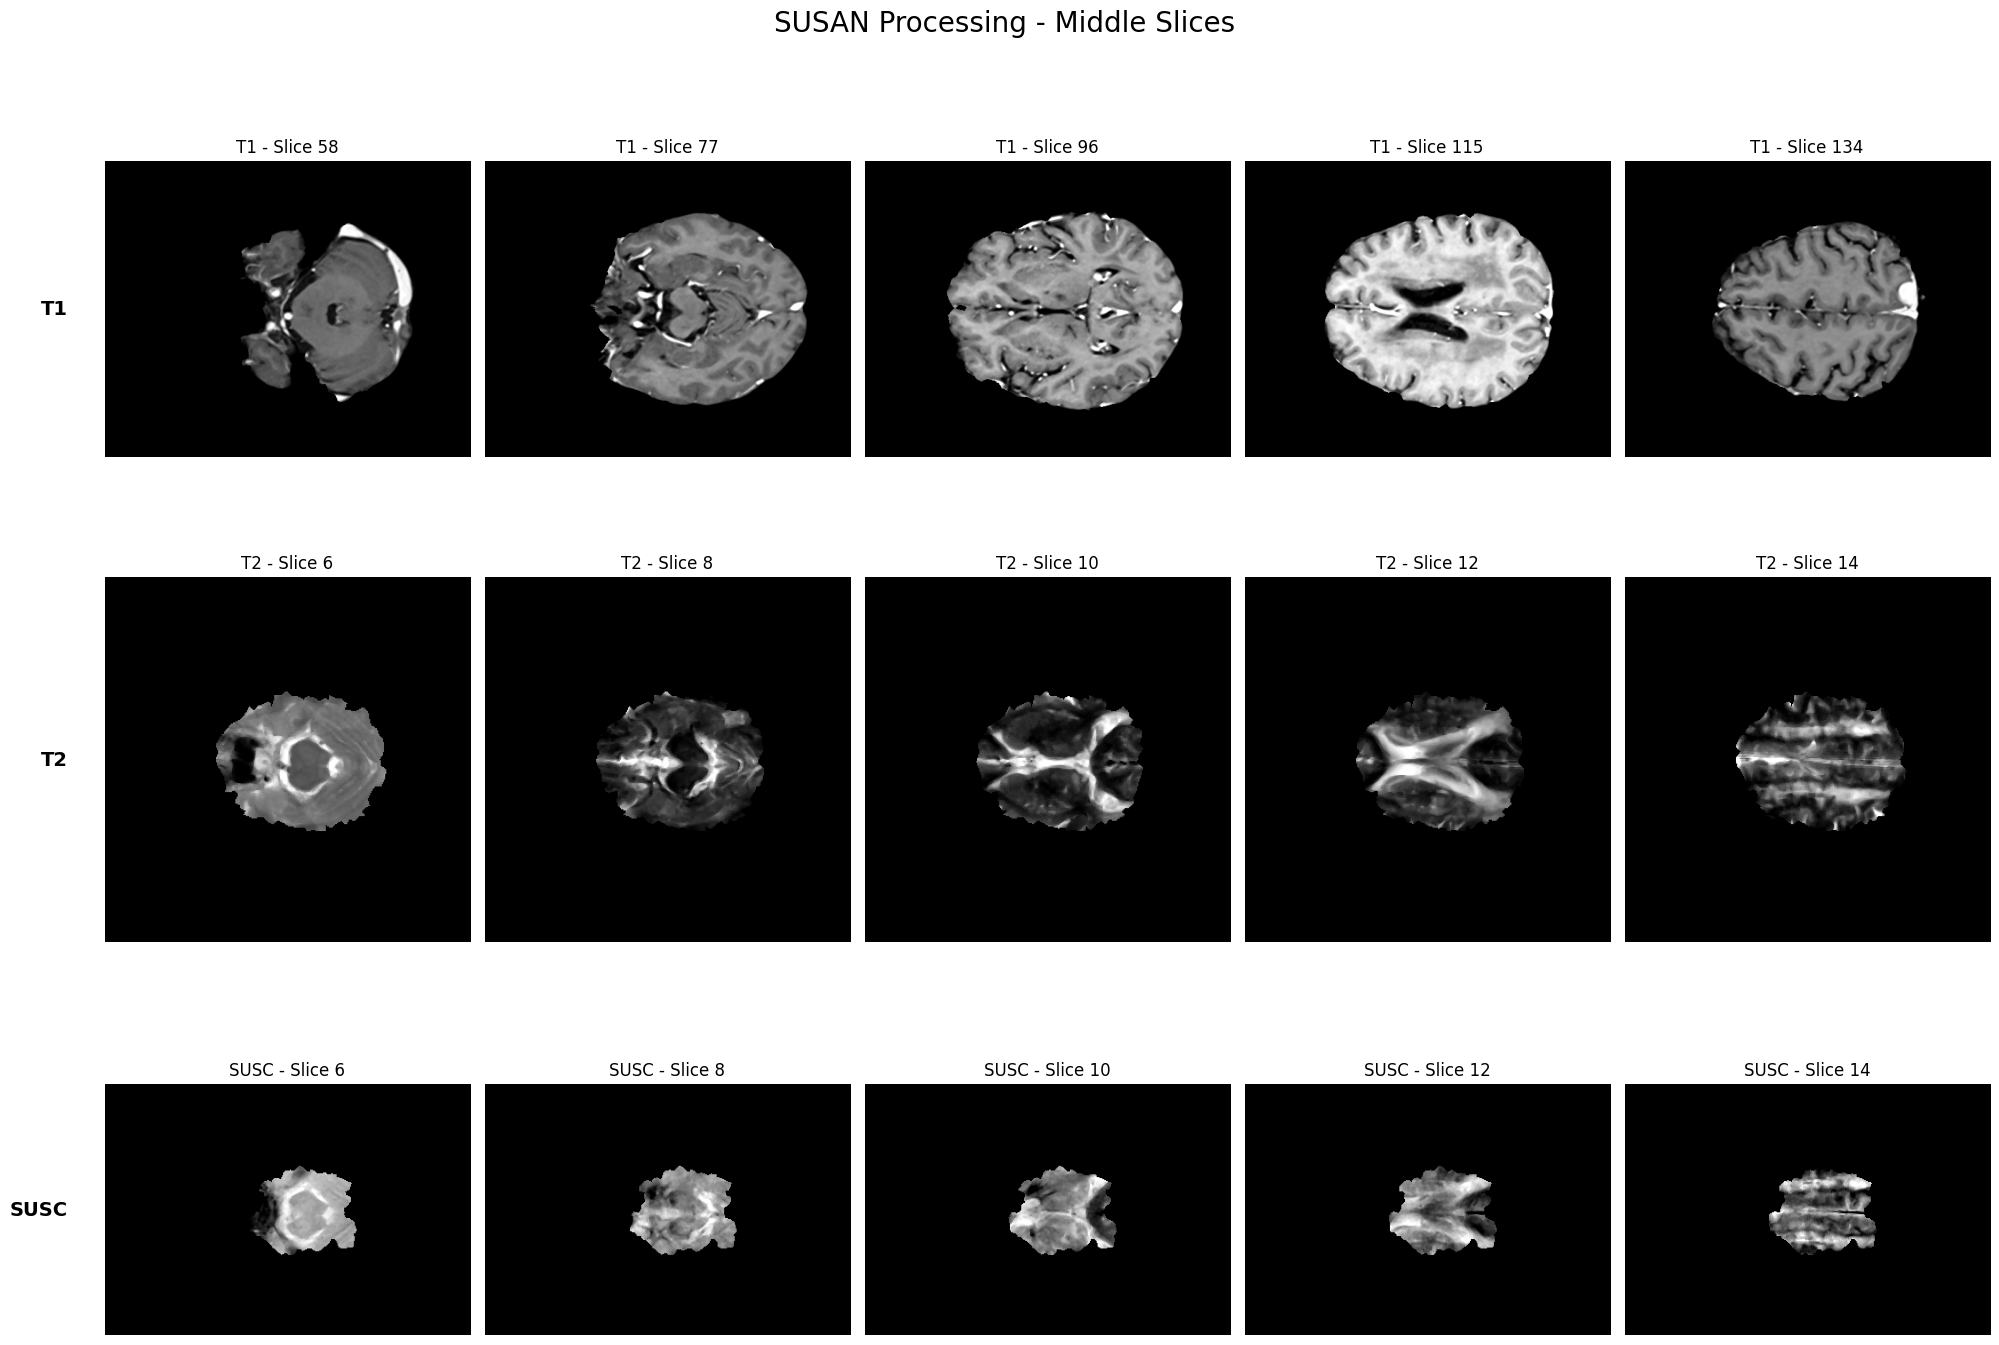

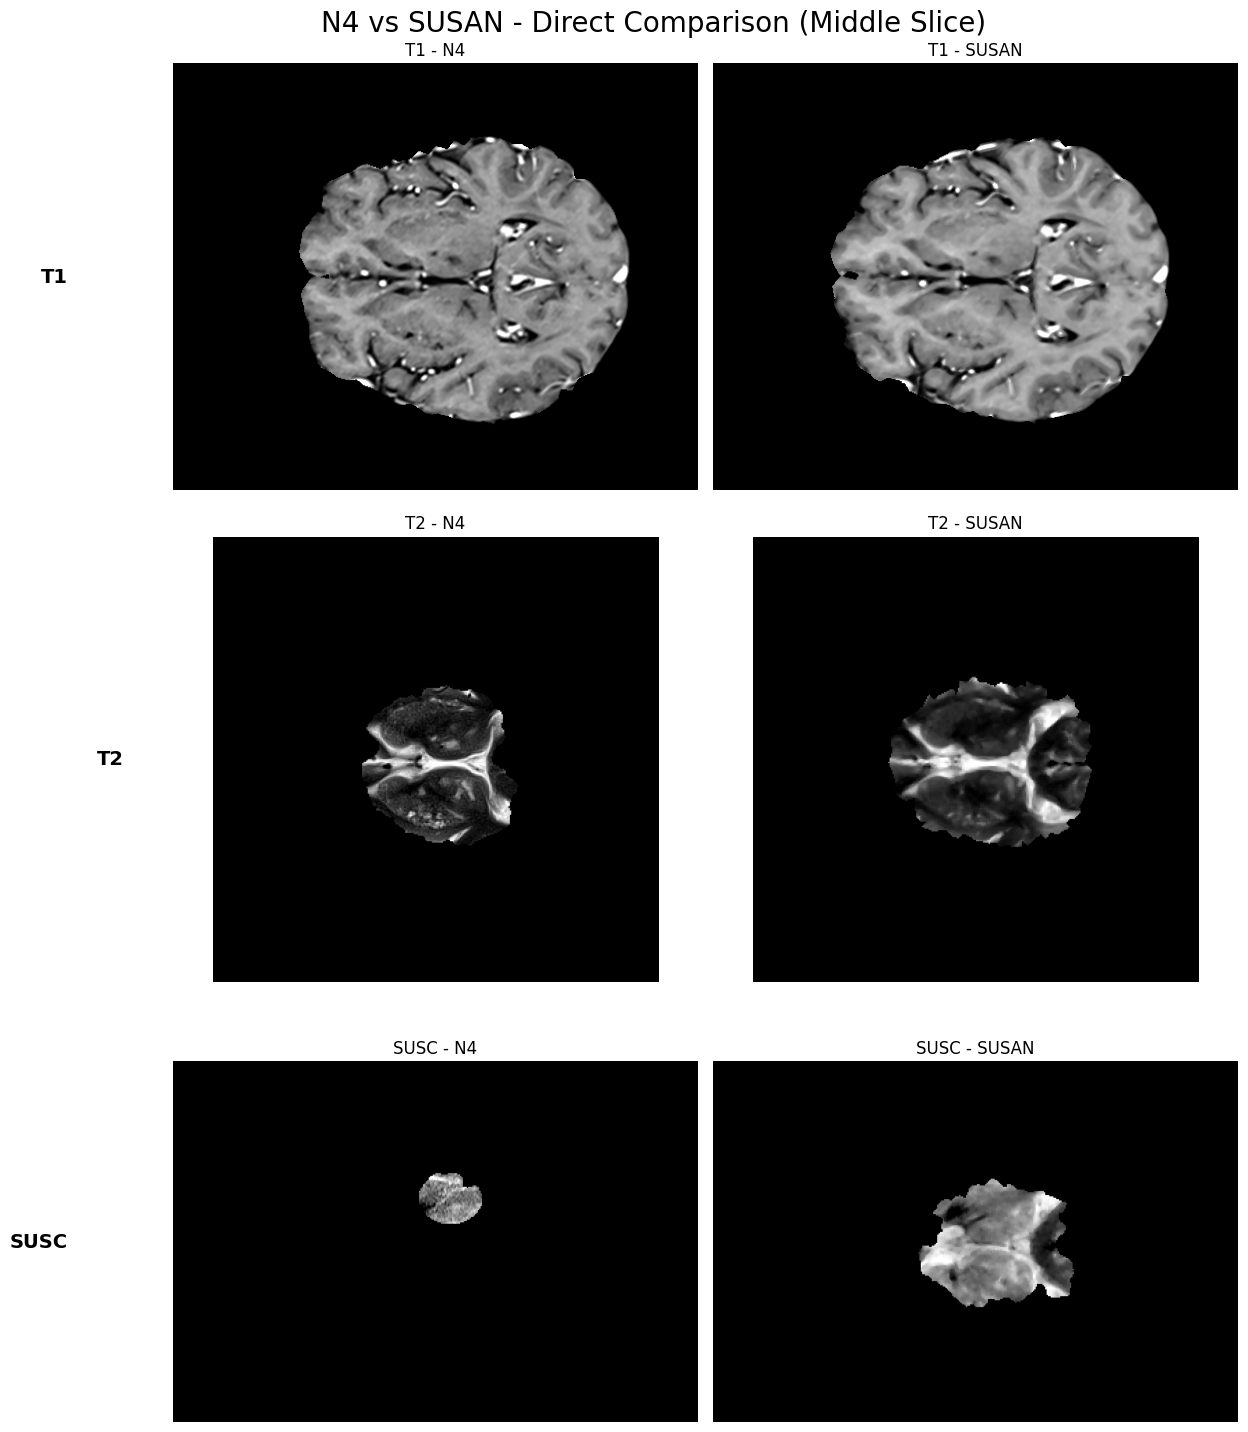

In [34]:
# Visualize the 5 middle slices for each pulse, comparing N4 and SUSAN separately
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk

# Define pulse-specific slice offsets if needed (based on where interesting features appear)
slice_offsets = {
    "T1": 0,
    "T2": 0,
    "SUSC": 0
}

# Get list of pulses
pulses = list(bet.keys())

# Function to normalize array for better visualization
def normalize_array(arr):
    mask = arr > 0
    if mask.any():
        p1, p99 = np.percentile(arr[mask], (1, 99))
        arr_norm = np.clip(arr, p1, p99)
        arr_norm = (arr_norm - p1) / (p99 - p1)
        return arr_norm
    return arr

# Create two figures - one for N4 and one for SUSAN
for processing_type in ["N4", "SUSAN"]:
    n_slices = 5  # Number of slices to display
    
    fig, axes = plt.subplots(len(pulses), n_slices, figsize=(20, 5*len(pulses)))
    fig.suptitle(f"{processing_type} Processing - Middle Slices", fontsize=20)
    
    # If only one pulse, make sure axes is 2D
    if len(pulses) == 1:
        axes = np.expand_dims(axes, axis=0)
    
    # Process each pulse
    for i, pulse in enumerate(pulses):
        # Get the appropriate volume based on processing type
        if processing_type == "N4":
            volume = bet[pulse]["brain_n4"]
        else:  # SUSAN
            volume = bet[pulse]["brain_susan"]
        
        # Convert to numpy array
        volume_array = sitk.GetArrayFromImage(volume)
        
        # Find middle slice and generate slice indices with offset
        middle_slice = volume_array.shape[2] // 2
        offset = slice_offsets.get(pulse, 0)
        
        # Calculate spacing between slices based on volume size
        slice_spacing = max(1, volume_array.shape[2] // 10)
        
        # Generate slice indices
        slice_indices = [
            middle_slice - 2*slice_spacing + offset,
            middle_slice - slice_spacing + offset,
            middle_slice + offset,
            middle_slice + slice_spacing + offset,
            middle_slice + 2*slice_spacing + offset
        ]
        
        # Process and display each slice
        for j, slice_idx in enumerate(slice_indices):
            # Ensure index is within bounds
            slice_idx = min(max(0, slice_idx), volume_array.shape[2]-1)
            
            # Get and normalize slice data
            slice_data = normalize_array(volume_array[:, :, slice_idx])
            
            # Display slice
            axes[i, j].imshow(slice_data, cmap='gray')
            axes[i, j].set_title(f"{pulse} - Slice {slice_idx}")
            axes[i, j].axis('off')
            
            # Add row labels for the first column
            if j == 0:
                axes[i, j].text(-0.1, 0.5, pulse, transform=axes[i, j].transAxes,
                              va='center', ha='right', fontsize=14, fontweight='bold')
        
    plt.tight_layout()
    plt.subplots_adjust(top=0.95, left=0.05)  # Adjust for title and row labels
    plt.show()

# Additionally, create a side-by-side comparison of N4 vs SUSAN for one slice per pulse
fig, axes = plt.subplots(len(pulses), 2, figsize=(12, 5*len(pulses)))
fig.suptitle("N4 vs SUSAN - Direct Comparison (Middle Slice)", fontsize=20)

# If only one pulse, make sure axes is 2D
if len(pulses) == 1:
    axes = np.expand_dims(axes, axis=0)

for i, pulse in enumerate(pulses):
    # Get volumes
    n4_volume = sitk.GetArrayFromImage(bet[pulse]["brain_n4"])
    susan_volume = sitk.GetArrayFromImage(bet[pulse]["brain_susan"])
    
    # Get middle slice with offset
    middle_slice = n4_volume.shape[2] // 2 + slice_offsets.get(pulse, 0)
    middle_slice = min(max(0, middle_slice), n4_volume.shape[2]-1)
    
    # Get and normalize slice data
    n4_slice = normalize_array(n4_volume[:, :, middle_slice])
    susan_slice = normalize_array(susan_volume[:, :, middle_slice])
    
    # Display slices side by side
    axes[i, 0].imshow(n4_slice, cmap='gray')
    axes[i, 0].set_title(f"{pulse} - N4")
    axes[i, 0].axis('off')
    
    axes[i, 1].imshow(susan_slice, cmap='gray')
    axes[i, 1].set_title(f"{pulse} - SUSAN")
    axes[i, 1].axis('off')
    
    # Add row labels
    axes[i, 0].text(-0.2, 0.5, pulse, transform=axes[i, 0].transAxes,
                  va='center', ha='right', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.subplots_adjust(top=0.95, left=0.1)
plt.show()